In [79]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import multiprocessing
import statsmodels.api as sm

In [2]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/

/mnt/datadisk2/aglv/aglv/lab_aglv


In [3]:
from forintern.DataDaily import DataDaily
datadaily = DataDaily()

load ./data_daily.h5...


In [5]:
r_win = 10

buy_l_order = datadaily.buy_value_large_order.loc[20210101:20231231]
sell_l_order = datadaily.sell_value_large_order.loc[20210101:20231231]
buy_xl_order = datadaily.buy_value_exlarge_order.loc[20210101:20231231]
sell_xl_order = datadaily.sell_value_exlarge_order.loc[20210101:20231231]

buy_s_order = datadaily.buy_value_small_order.loc[20210101:20231231]
sell_s_order = datadaily.sell_value_small_order.loc[20210101:20231231]

buy_l_order_act = datadaily.buy_value_large_order_act.loc[20210101:20231231]
buy_l_order_act_os = datadaily.buy_value_large_order_act.loc[20231231:20231231]
sell_l_order_act = datadaily.sell_value_large_order_act.loc[20210101:20231231]
buy_xl_order_act = datadaily.buy_value_exlarge_order_act.loc[20210101:20231231]
sell_xl_order_act = datadaily.sell_value_exlarge_order_act.loc[20210101:20231231]

buy_l_order_demean = buy_l_order / buy_l_order.rolling(r_win).mean()
sell_l_order_demean = sell_l_order / sell_l_order.rolling(r_win).mean()
buy_xl_order_demean = buy_xl_order / buy_xl_order.rolling(r_win).mean()
sell_xl_order_demean = sell_xl_order / sell_xl_order.rolling(r_win).mean()

buy_l_order_act_demean = buy_l_order_act / buy_l_order_act.rolling(r_win).mean()
sell_l_order_act_demean = sell_l_order_act / sell_l_order_act.rolling(r_win).mean()
buy_xl_order_act_demean = buy_xl_order_act / buy_xl_order_act.rolling(r_win).mean()
sell_xl_order_act_demean = sell_xl_order_act / sell_xl_order_act.rolling(r_win).mean()

buy_l_s_ratio = buy_l_order / buy_s_order
sell_l_s_ratio = sell_l_order / sell_s_order

In [83]:
path_factor = '/mnt/datadisk2/aglv/aglv/aglv_factor/new_pvol/'

In [7]:

def factor_distribution_plot(data):
    '''
    将因子值二维数组转化为分布图形式
    '''
    import seaborn as sns

    if len(data.shape) > 1:
        data = data.stack()

    plt.figure(figsize=(10, 6))

    plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')
    sns.kdeplot(data, color='red', label='KDE')

    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

    plt.show()

def factor_self_corr(factor:pd.DataFrame, gap=1, win=20):
    '''因子自相关性检测'''
    if len(factor.shape) < 1:
        if 'date' in factor.columns:
            factor = factor.set_index('date')
        elif 'Date' in factor.columns:
            factor = factor.set_index('Date')
    
    factor.index = [str(i) for i in factor.index]

    factor_corr = factor.rolling(win).apply(lambda x: x.corr(x.shift(-1)))

    plt.figure(figsize=(12, 6))
    plt.plot(factor_corr)
    plt.tight_layout()
    plt.xticks(ticks=range(0, len(factor_corr), max(1, len(factor_corr)//10)), 
               labels=factor_corr.index[::max(1, len(factor_corr)//10)], rotation=45)
    plt.show()

def factor_plot(factor:pd.DataFrame, gap=1, win=20):
    '''因子值绘图检测'''
    if len(factor.shape) < 1:
        if 'date' in factor.columns:
            factor = factor.set_index('date')
        elif 'Date' in factor.columns:
            factor = factor.set_index('Date')
    
    factor.index = [str(i) for i in factor.index]

    plt.figure(figsize=(12, 6))
    plt.plot(factor, color='#FF9999')
    plt.tight_layout()
    plt.xticks(ticks=range(0, len(factor), max(1, len(factor)//10)), 
               labels=factor.index[::max(1, len(factor)//10)], rotation=45)
    plt.title(f'Factor Plot')
    plt.show()

def ic_plot(factor, ret):
    '''绘制月度ic和累计ic情况'''
    def get_ic_series(factor, ret):
        icall = pd.DataFrame()
        fall = pd.merge(factor, ret, left_on=['date', 'stock'], right_on=['date', 'stock'])
        icall = fall.groupby('date').apply(lambda x : x.corr()['ret']).reset_index()
        icall = icall.dropna().drop(['ret'], axis=1).set_index('date')

        return icall
    
    ic_f = get_ic_series(factor, ret)
    f_name = ic_f.columns[0]
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes()
    xtick = np.arange(0, ic_f.shape[0], 20)
    xtick_label = pd.Series(ic_f.index[xtick])
    plt.bar(np.arange(ic_f.shape[0]), ic_f[f_name], color='darkred')
    
    ax1 = plt.twinx()
    ax1.plot(np.arange(ic_f.shape[0], ic_f.cumsum(), color='orange'))

    ax.set_xticks(xtick)
    ax.set_yticks(xtick_label)

    plt.show()

In [8]:
data2123 = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/data21_23.h5')

In [9]:
data2123 = data2123[['Close', 'LastVolume']]
data2123

Close  LastVolume
Date     InstrumentID EndTime                   
20210104 SZ000001     09:31    18.90   3155510.0
                      09:32    18.80   1791334.0
                      09:33    18.84   1656900.0
                      09:34    18.67   2376914.0
                      09:35    18.57   2616000.0
...                              ...         ...
20231012 SH689009     14:56    33.88     23275.0
                      14:57    33.89      9297.0
                      14:58    33.89         0.0
                      14:59    33.89         0.0
                      15:00    33.77     62011.0

[751830321 rows x 2 columns]

In [10]:
volmin = data2123['LastVolume']
pmin = data2123['Close']

In [11]:
volmin = volmin.unstack(level='InstrumentID')

In [12]:
volmin

InstrumentID       SH600000  SH600004    SH600006  SH600007   SH600008  \
Date     EndTime                                                         
20210104 09:31    1727980.0  257345.0  10138000.0   30600.0  1489000.0   
         09:32     865050.0  255293.0   5092700.0    3400.0   718700.0   
         09:33     877830.0  172506.0   6881859.0    4800.0   317300.0   
         09:34     835670.0  225664.0   3533000.0   11100.0   165400.0   
         09:35     436000.0  164867.0   2236900.0   23900.0   598760.0   
...                     ...       ...         ...       ...        ...   
20231012 14:56     208100.0   53500.0    199400.0    7600.0   187700.0   
         14:57      37650.0   70570.0     97100.0   18900.0   251800.0   
         14:58          0.0       0.0         0.0       0.0        0.0   
         14:59          0.0       0.0         0.0       0.0        0.0   
         15:00     783409.0   96900.0    247700.0   21400.0   608700.0   

InstrumentID      SH600009   SH600010   SH600011  SH600012   SH600015  ...  \
Date     EndTime                                                       ...   
20210104 09:31    390317.0  3122500.0  1089300.0  145500.0  1319700.0  ...   
         09:32    325080.0  2368340.0   638800.0   47500.0   443500.0  ...   
         09:33    256800.0  1626100.0   760900.0   21300.0   214400.0  ...   
         09:34    159200.0  1754700.0   571700.0   33000.0   169100.0  ...   
         09:35    347600.0  1981840.0  1363400.0   45400.0   615100.0  ...   
...                    ...        ...        ...       ...        ...  ...   
20231012 14:56     75952.0  2682200.0   163000.0    6300.0   223100.0  ...   
         14:57     45948.0   618500.0   209300.0   12500.0   386700.0  ...   
         14:58         0.0        0.0        0.0       0.0        0.0  ...   
         14:59         0.0        0.0        0.0       0.0        0.0  ...   
         15:00     78600.0  3681200.0   680000.0   18000.0   400700.0  ...   

InstrumentID      SZ301519  SZ301520  SZ301525  SZ301528  SZ301529  SZ301533  \
Date     EndTime                                                               
20210104 09:31         NaN       NaN       NaN       NaN       NaN       NaN   
         09:32         NaN       NaN       NaN       NaN       NaN       NaN   
         09:33         NaN       NaN       NaN       NaN       NaN       NaN   
         09:34         NaN       NaN       NaN       NaN       NaN       NaN   
         09:35         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
20231012 14:56     38900.0   17200.0   14406.0   12900.0   53300.0    8600.0   
         14:57     27400.0   39900.0    5000.0    8100.0   46502.0    7300.0   
         14:58         0.0       0.0       0.0       0.0       0.0       0.0   
         14:59         0.0       0.0       0.0       0.0       0.0       0.0   
         15:00     35500.0   49700.0   23000.0   40400.0   52500.0   22300.0   

InstrumentID      SZ301548  SZ301550  SZ301558  SZ301559  
Date     EndTime                                          
20210104 09:31         NaN       NaN       NaN       NaN  
         09:32         NaN       NaN       NaN       NaN  
         09:33         NaN       NaN       NaN       NaN  
         09:34         NaN       NaN       NaN       NaN  
         09:35         NaN       NaN       NaN       NaN  
...                    ...       ...       ...       ...  
20231012 14:56     20500.0   23500.0  424700.0  202340.0  
         14:57     15600.0   67100.0  527929.0  349243.0  
         14:58         0.0       0.0       0.0       0.0  
         14:59         0.0       0.0       0.0       0.0  
         15:00     36600.0  106100.0  703611.0  334955.0  

[161118 rows x 5175 columns]

In [22]:
volmin_stock_per = volmin.groupby(level='Date').progress_apply(lambda x: x/x.mean())

<ipython-input-37-b75c6d00e953>:1: RuntimeWarning: divide by zero encountered in log
  factor_distribution_plot(np.log(volmin_stock_per.iloc[:240]).replace(-np.inf, np.nan))


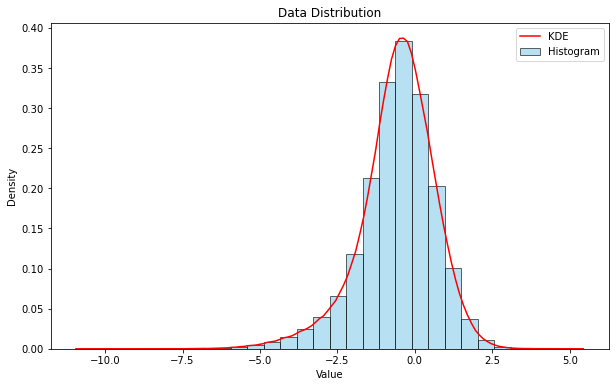

In [37]:
factor_distribution_plot(np.log(volmin_stock_per.iloc[:240]).replace(-np.inf, np.nan))

In [150]:
data2123

Close  LastVolume
Date     InstrumentID EndTime                   
20210104 SZ000001     09:31    18.90   3155510.0
                      09:32    18.80   1791334.0
                      09:33    18.84   1656900.0
                      09:34    18.67   2376914.0
                      09:35    18.57   2616000.0
...                              ...         ...
20231012 SH689009     14:56    33.88     23275.0
                      14:57    33.89      9297.0
                      14:58    33.89         0.0
                      14:59    33.89         0.0
                      15:00    33.77     62011.0

[751830321 rows x 2 columns]

In [163]:
min_gap = 5
def agg_series(s:pd.Series, agg_num=5, method='sum'):
    s.index = list(range(len(s)))
    if method == 'sum':
        s_agg = s.groupby(s.index // agg_num).sum()
    elif method == 'prod':
        s_agg = s.groupby(s.index // agg_num).prod()

    return s_agg

In [166]:
eg = data2123.xs('20210104', level='Date')
eg

Close  LastVolume
InstrumentID EndTime                   
SZ000001     09:31    18.90   3155510.0
             09:32    18.80   1791334.0
             09:33    18.84   1656900.0
             09:34    18.67   2376914.0
             09:35    18.57   2616000.0
...                     ...         ...
SH689009     14:56    88.50     38656.0
             14:57    88.35    101104.0
             14:58    88.35         0.0
             14:59    88.35         0.0
             15:00    88.20    152923.0

[989520 rows x 2 columns]

In [171]:
egclo = eg['Close'].unstack().T
egclo

InstrumentID,SZ000001,SZ000002,SZ000004,SZ000005,SZ000006,SZ000007,SZ000008,SZ000009,SZ000010,SZ000011,...,SH688668,SH688678,SH688679,SH688686,SH688698,SH688699,SH688777,SH688788,SH688981,SH689009
EndTime,,,,,,,,,,,,,,,,,,,,,
09:31,18.90,28.15,20.66,2.52,5.60,6.27,2.53,7.49,4.21,12.12,...,29.92,21.73,15.35,225.88,17.89,55.21,100.37,135.40,57.76,85.81
09:32,18.80,28.07,20.55,2.53,5.58,6.27,2.53,7.54,4.15,12.08,...,30.15,21.82,15.30,224.50,18.06,55.07,100.21,135.34,57.74,86.00
09:33,18.84,27.96,20.65,2.52,5.58,6.27,2.53,7.57,4.10,12.08,...,30.10,21.80,15.30,225.25,17.90,55.41,99.90,135.10,57.29,84.80
09:34,18.67,27.93,20.64,2.52,5.59,6.27,2.52,7.54,4.04,12.11,...,30.02,21.87,15.39,229.00,18.00,55.10,99.98,135.10,56.76,84.44
09:35,18.57,27.99,20.58,2.52,5.57,6.27,2.52,7.55,4.05,12.02,...,29.97,21.95,15.37,230.20,17.85,55.00,99.39,134.10,57.04,85.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14:56,18.62,27.75,21.01,2.52,5.53,6.27,2.52,7.80,4.07,12.02,...,30.67,22.27,15.26,258.00,18.49,56.21,105.13,142.51,58.24,88.50
14:57,18.60,27.78,21.02,2.52,5.52,6.27,2.53,7.79,4.06,12.00,...,30.67,22.35,15.26,257.80,18.49,56.29,105.07,142.91,58.25,88.35
14:58,18.60,27.78,21.02,2.52,5.52,6.27,2.53,7.79,4.06,12.00,...,30.67,22.35,15.26,257.80,18.49,56.29,105.07,142.91,58.25,88.35


In [199]:
n_processing = 64

def handle_stockly(data_stock: pd.DataFrame):
    '''对单只股票的处理函数, 可以是日频的也可以是分钟频的数据, 返回一个日频的series'''
    min_gap = 5

    def agg_series(s:pd.Series, agg_num=min_gap, method='sum'):
        s.index = list(range(len(s)))
        if method == 'sum':
            s_agg = s.groupby(s.index // agg_num).sum()
        elif method == 'prod':
            s_agg = s.groupby(s.index // agg_num).prod()

        return s_agg

    over_std_value = 1
    pmin = data_stock['Close'].unstack().T
    retmin = pmin.apply(lambda x: x / x.shift(1))
    retmin = agg_series(retmin, method='prod') - 1
    retmin = ((retmin.T - retmin.mean(axis=1)) / retmin.std(axis=1)).T

    is_pass = retmin.applymap(lambda x: 1 if abs(x) > over_std_value else 0)

    volmin = data_stock['LastVolume'].unstack().T
    volmin = agg_series(volmin, method='sum')
    vol_over1std_per = (volmin * is_pass).sum()
    vol_over1std_per.index

    return vol_over1std_per


def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    # date_name = 'date' if 'date' in data.index.names else 'Date'
    date_name = 'Date'
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            # index=factor.index.get_level_values(date_name), 
            # factor.index,
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [200]:
vol_over1std_per = multiprocessing_factor(data2123)

In [245]:
n_processing = 64

def handle_stockly(data_stock: pd.DataFrame):
    '''对单只股票的处理函数, 可以是日频的也可以是分钟频的数据, 返回一个日频的series'''


    over_std_value = 1
    pmin = data_stock['Close'].unstack()
    retmin = pmin.apply(lambda x: x / x.shift(1), axis=1)
    retmin_zs = ((retmin.T - retmin.mean(axis=1)) / retmin.std(axis=1)).T

    is_pass = retmin_zs.applymap(lambda x: x/abs(x) if abs(x) > over_std_value else 0)

    volmin = data_stock['LastVolume'].unstack()
    # volmin = agg_series(volmin, method='sum')
    volmin_log = np.log(volmin.replace(0, np.nan))
    vol_over1std_per = (volmin_log * is_pass).sum(axis=1)
    # vol_over1std_per.index

    return vol_over1std_per


def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    # date_name = 'date' if 'date' in data.index.names else 'Date'
    date_name = 'Date'
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            index=factor.index.get_level_values(date_name), 
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [239]:
vol_p_over1std_symbol = multiprocessing_factor(data2123)

<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipython-input-238-ab714ce3888d>:16: RuntimeWarning: divide by zero encountered in log
  volmin_log = np.log(volmin).replace(-np.inf, np.nan)
<ipyth

In [244]:
vol_p_over1std_symbol.index = [int(i) for i in vol_p_over1std_symbol.index]
vol_p_over1std_symbol_r10mean_r10std_ratio = vol_p_over1std_symbol.rolling(10).mean() / vol_p_over1std_symbol.rolling(10).std()
vol_p_over1std_symbol.to_csv(path_factor + 'vol_p_over1std_symbol_r10mean_r10std_ratio.csv')

In [204]:
data2123.index.get_level_values('Date').unique()

Index(['20210104', '20210105', '20210106', '20210107', '20210108', '20210111',
       '20210112', '20210113', '20210114', '20210115',
       ...
       '20230921', '20230922', '20230925', '20230926', '20230927', '20230928',
       '20231009', '20231010', '20231011', '20231012'],
      dtype='object', name='Date', length=671)

In [205]:
vol_over1std_per.index = data2123.index.get_level_values('Date').unique()
vol_over1std_per

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
Date,,,,,,,,,,,,,,,,,,,,,
20210104,22582684.0,5376101.0,95102493.0,159200.0,14167391.0,11809837.0,82762874.0,1109600.0,1596618.0,7490850.0,...,12281248.0,7374983.0,10491799.0,5725299.0,12566743.0,11629450.0,7494469.0,6609823.0,65682423.0,0.0
20210105,17957855.0,6064876.0,116230522.0,161700.0,18777380.0,5635158.0,182180500.0,2010700.0,3552717.0,9520780.0,...,21101418.0,3385846.0,6565176.0,4033663.0,4956161.0,11387319.0,3959284.0,5648943.0,14956484.0,0.0
20210106,24319605.0,2480726.0,63109485.0,663949.0,12739730.0,9785776.0,51403852.0,7028257.0,15400797.0,9131225.0,...,14781540.0,7279788.0,3328777.0,2571496.0,9068744.0,5928118.0,1778515.0,3144990.0,15397938.0,NaN
20210107,25051602.0,13840099.0,116391125.0,793100.0,24517834.0,6253152.0,268610733.0,8621900.0,2390400.0,11745158.0,...,11217098.0,4034315.0,3596022.0,1349125.0,6008107.0,4438511.0,757709.0,2769101.0,16383808.0,NaN
20210108,24854976.0,11104724.0,68876613.0,461700.0,59568782.0,5367025.0,188675934.0,12592036.0,4141396.0,7206840.0,...,14276655.0,2420950.0,2638290.0,972648.0,5558178.0,3000587.0,2114253.0,630955.0,4895664.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,8668539.0,0.0,NaN,44000.0,11995602.0,NaN,47422060.0,0.0,NaN,7739375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231009,9745498.0,4687628.0,NaN,82800.0,13996152.0,NaN,15606000.0,2246600.0,NaN,15403813.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231010,11348074.0,3221300.0,NaN,185280.0,18553803.0,NaN,17548100.0,5483000.0,NaN,10913673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
vol_day = datadaily.volume.loc[20210101:20231012]
vol_over1std_per.index = [int(i) for i in vol_over1std_per.index]
vol_over1std_per_agg5 = vol_over1std_per / vol_day

In [209]:
vol_over1std_per_agg5.isna().sum(axis=1)

20210104    1513
20210105    1512
20210106    1510
20210107    1505
20210108    1504
            ... 
20230928    1928
20231009    1955
20231010    2006
20231011    2091
20231012    2557
Length: 671, dtype: int64

In [210]:
vol_over1std_per_agg5.to_csv(path_factor + 'vol_over1std_per_agg5.csv')

In [100]:
def dropinf(data):
    return data.replace(np.inf, np.nan).replace(-np.inf, np.nan)

<ipython-input-101-b876013d5095>:1: RuntimeWarning: divide by zero encountered in log
  factor_distribution_plot(dropinf(np.log(vol_over1std_per)))


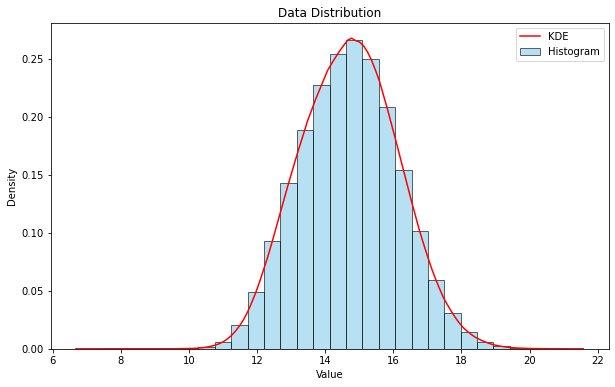

In [101]:
factor_distribution_plot(dropinf(np.log(vol_over1std_per)))

In [93]:
vol_over1std_per_r10mean = vol_over1std_per.rolling(10).mean()

In [122]:
vol_over1std_per.index = [int(i) for i in vol_over1std_per.index]

In [126]:
vol_over1std_per_blorder_ratio = buy_l_order - vol_over1std_per

<ipython-input-128-f80366a33686>:1: RuntimeWarning: divide by zero encountered in log
  factor_distribution_plot(dropinf(np.log(vol_over1std_per_blorder_ratio)))
<ipython-input-128-f80366a33686>:1: RuntimeWarning: invalid value encountered in log
  factor_distribution_plot(dropinf(np.log(vol_over1std_per_blorder_ratio)))


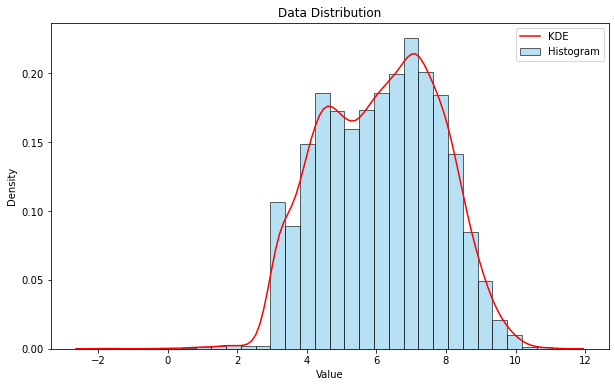

In [128]:
factor_distribution_plot(dropinf(np.log(vol_over1std_per_blorder_ratio)))

In [129]:
dropinf(np.log(vol_over1std_per_blorder_ratio)).to_csv(path_factor+ 'vol_over1std_per_blorder_ratio_log.csv')

<ipython-input-129-a6a06f797c7e>:1: RuntimeWarning: divide by zero encountered in log
  dropinf(np.log(vol_over1std_per_blorder_ratio)).to_csv(path_factor+ 'vol_over1std_per_blorder_ratio_log.csv')
<ipython-input-129-a6a06f797c7e>:1: RuntimeWarning: invalid value encountered in log
  dropinf(np.log(vol_over1std_per_blorder_ratio)).to_csv(path_factor+ 'vol_over1std_per_blorder_ratio_log.csv')


In [94]:
vol_over1std_per_r10mean.to_csv(path_factor + 'vol_ret_over1std_per_r1mean.csv')

In [73]:
# lead-lag
shift_day = 0
r_win = 20
n_processing = 64

def handle_stockly(data_stock: pd.DataFrame):
    '''对单只股票的处理函数, 可以是日频的也可以是分钟频的数据, 返回一个日频的series'''
    lag_range = list(range(-3, 10, 3))
    def agg_series(s:pd.Series, agg_num=48):
        s.index = list(range(len(s)))
        s_agg = s.groupby(s.index // agg_num).sum()
        
        return s_agg

    def handle_stockly_daily(data_stock_daily:pd.Series):
        return max(
            [agg_series(data_stock_daily.iloc[:, 0]).corr(agg_series(data_stock_daily.iloc[:, 1]).shift(lag_min)) for lag_min in lag_range]
            )

    return data_stock.groupby(level='Date').apply(handle_stockly_daily)


def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    date_name = 'date' if 'date' in data.index.names else 'Date'
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            index=factor.index.get_level_values(date_name), 
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [74]:
p_vol_lag_corr = multiprocessing_factor(data2123)

KeyboardInterrupt: 

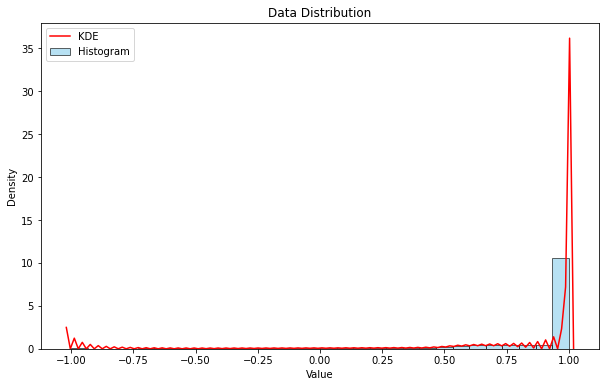

In [15]:
factor_distribution_plot(p_vol_lag_corr)

In [16]:
p_vol_lag_corr.to_csv(path_factor + 'p_vol_lag_corr.csv')

### 成交量在价格上的分布

In [72]:
data2123

Close  LastVolume
Date     InstrumentID EndTime                   
20210104 SZ000001     09:31    18.90   3155510.0
                      09:32    18.80   1791334.0
                      09:33    18.84   1656900.0
                      09:34    18.67   2376914.0
                      09:35    18.57   2616000.0
...                              ...         ...
20231012 SH689009     14:56    33.88     23275.0
                      14:57    33.89      9297.0
                      14:58    33.89         0.0
                      14:59    33.89         0.0
                      15:00    33.77     62011.0

[751830321 rows x 2 columns]

In [56]:
eg = data2123.xs('20210104', level='Date').xs('SZ000001', level='InstrumentID')
eg

,Close,LastVolume
EndTime,,
09:31,18.90,3155510.0
09:32,18.80,1791334.0
09:33,18.84,1656900.0
09:34,18.67,2376914.0
09:35,18.57,2616000.0
...,...,...
14:56,18.62,491226.0
14:57,18.60,1050700.0
14:58,18.60,0.0


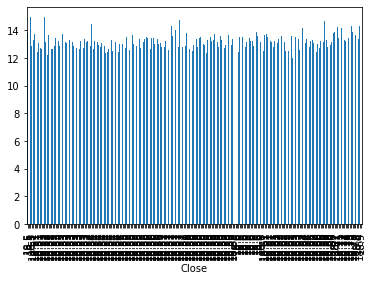

In [57]:
eg2 = eg.set_index('Close')
np.log(eg2['LastVolume'].replace(0, np.nan)).sort_index().plot(kind='bar')

In [58]:
np.log(eg2['LastVolume'].replace(0, np.nan)).std()

0.5310735778997406

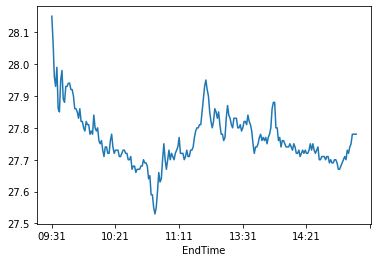

In [33]:
eg['Close'].plot()

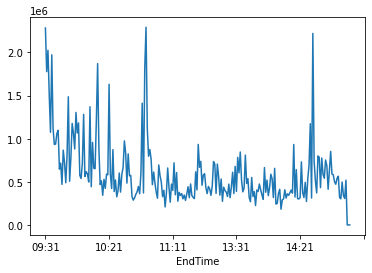

In [35]:
eg['LastVolume'].plot()

In [34]:
g_num = 10
min_s, max_s = eg['Close'].min(), eg['Close'].max()
p_range = np.linspace(min_s, max_s, g_num)
# p_range, min_s, max_s
eg['cate'] = pd.cut(eg['Close'], p_range)
grouped = eg.groupby('cate').sum()['LastVolume']
# grouped_desum = grouped / grouped.sum()
# grouped_desum.idxmax().left
# grouped.sort_values(ascending=False)
grouped

cate
(27.53, 27.599]      6097048.0
(27.599, 27.668]     4677690.0
(27.668, 27.737]    51729707.0
(27.737, 27.806]    34663065.0
(27.806, 27.874]    25284039.0
(27.874, 27.943]    11785626.0
(27.943, 28.012]     5638155.0
(28.012, 28.081]     1777300.0
(28.081, 28.15]      2283300.0
Name: LastVolume, dtype: float64

In [50]:
from IPython.display import display, clear_output
import time
for i in range(100):
    clear_output()
    display(i)
    time.sleep(0.1)

99

In [13]:
# lead-lag
shift_day = 0
r_win = 20
n_processing = 64

def handle_stockly(data_stock: pd.DataFrame):
    '''对单只股票的处理函数, 可以是日频的也可以是分钟频的数据, 返回一个日频的series'''

    def handle_stockly_daily(data_stock_daily:pd.Series):
        g_num = 10
        min_s, max_s = data_stock_daily['Close'].min(), data_stock_daily['Close'].max()

        if min_s == max_s:
            return np.nan
        
        p_range = np.linspace(min_s, max_s, g_num)
        data_stock_daily['cate'] = pd.cut(data_stock_daily['Close'], p_range)
        g_value_vol = data_stock_daily.groupby('cate').sum()['LastVolume']
        p_volmax_iv = g_value_vol.iloc[:int(g_num/2)].idxmax()
        p_volmax = (p_volmax_iv.left + p_volmax_iv.right) / 2

        return p_volmax

    return data_stock.groupby(level='Date').apply(handle_stockly_daily)


def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    date_name = 'date' if 'date' in data.index.names else 'Date'
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            index=factor.index.get_level_values(date_name), 
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [78]:
p_volmax = multiprocessing_factor(data2123)

In [79]:
p_volmax

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
20210104,9.5885,13.9730,9.2675,12.3950,2.8585,77.3400,1.1790,4.5015,6.0835,6.2205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,9.5550,13.7865,8.7295,12.5300,2.8500,76.9535,1.1700,4.3750,6.0945,6.1860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,9.8095,13.5165,8.4900,12.6450,2.8385,77.0130,1.1695,4.3685,6.3315,6.2630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,9.7570,12.8165,8.4215,12.4050,2.8010,75.9485,1.1785,4.3780,6.1880,6.2435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,9.8215,13.1115,8.1955,12.3905,2.8935,75.8735,1.1695,4.4565,6.1185,6.2370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,7.1365,11.1285,5.5565,19.3800,2.8400,37.8685,1.7200,7.8675,11.0495,5.7210,...,24.3380,77.0025,107.7755,84.8250,46.5065,43.6700,66.7600,46.6525,19.8795,NaN
20231009,7.0400,10.8020,5.6405,19.3265,2.8185,37.0770,1.7200,7.8725,11.1035,5.6865,...,23.7355,71.8815,105.9085,83.8565,46.5050,42.5965,63.9820,48.1050,15.5030,NaN
20231010,7.0435,10.8150,5.7150,18.9695,2.8200,37.1950,1.7185,7.7335,10.9900,5.6600,...,23.2020,68.2450,104.0230,82.7525,45.0590,41.7125,61.8790,49.9445,15.0760,NaN
20231011,7.0220,10.7255,5.6650,19.1500,2.8100,36.9865,1.7200,7.6310,10.7515,5.6195,...,22.9300,68.0685,103.9290,81.7980,45.3950,41.3250,61.9335,49.3355,14.7575,24.6165


In [85]:
p_volmax.index = [int(i) for i in p_volmax.index]

In [86]:
clo_day = datadaily.close.loc[20210101: 20231231]

In [87]:
p_volmax_clo_ret = (clo_day - p_volmax) / p_volmax

In [90]:
# p_volmax_clo_ret.to_csv(path_factor + 'p_volmax_clo_ret.csv')

In [92]:
p_volmax_ret = p_volmax_clo_ret.pct_change()
p_volmax_r10mean = (p_volmax - p_volmax.shift(10)) / p_volmax.shift(10)
p_volmax_r10std = (p_volmax / p_volmax.rolling(10).mean()).rolling(10).std()

In [93]:
p_volmax_ret.to_csv(path_factor + 'p_volmax_ret.csv')
p_volmax_r10mean.to_csv(path_factor + 'p_volmax_r10mean.csv')
p_volmax_r10std.to_csv(path_factor + 'p_volmax_r10std.csv')

In [97]:
open_day = datadaily.open_.loc[20210101:20231231]

In [106]:
open_clo_daily = pd.concat([clo_day.unstack(), open_day.unstack()], axis=1)
open_clo_daily.columns = ['open', 'clo']
open_clo_daily

open  clo
InstrumentID date               
BJ430017     20210104   NaN  NaN
             20210105   NaN  NaN
             20210106   NaN  NaN
             20210107   NaN  NaN
             20210108   NaN  NaN
...                     ...  ...
SZ301633     20231225   NaN  NaN
             20231226   NaN  NaN
             20231227   NaN  NaN
             20231228   NaN  NaN
             20231229   NaN  NaN

[4097372 rows x 2 columns]

In [218]:
low_high_daily = pd.concat([datadaily.low.loc[20210101:20231231].unstack(), datadaily.high.loc[20210101:20231231].unstack()], axis=1)
low_high_daily.columns = ['low', 'high']
low_high_daily

low  high
InstrumentID date               
BJ430017     20210104  NaN   NaN
             20210105  NaN   NaN
             20210106  NaN   NaN
             20210107  NaN   NaN
             20210108  NaN   NaN
...                    ...   ...
SZ301633     20231225  NaN   NaN
             20231226  NaN   NaN
             20231227  NaN   NaN
             20231228  NaN   NaN
             20231229  NaN   NaN

[4097372 rows x 2 columns]

In [134]:
def f(x, y):
    if x.isna().sum() + y.isna().sum() == 0:
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        res = model.fit()
        if len(res.params) == 2:
            return res.params.iloc[1]
        else:
            return np.nan
    else:
        return np.nan

In [224]:
open_clo_daily

open  clo
InstrumentID date               
BJ430017     20210104   NaN  NaN
             20210105   NaN  NaN
             20210106   NaN  NaN
             20210107   NaN  NaN
             20210108   NaN  NaN
...                     ...  ...
SZ301633     20231225   NaN  NaN
             20231226   NaN  NaN
             20231227   NaN  NaN
             20231228   NaN  NaN
             20231229   NaN  NaN

[4097372 rows x 2 columns]

In [227]:
p_volmax

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
20210104,9.5885,13.9730,9.2675,12.3950,2.8585,77.3400,1.1790,4.5015,6.0835,6.2205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,9.5550,13.7865,8.7295,12.5300,2.8500,76.9535,1.1700,4.3750,6.0945,6.1860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,9.8095,13.5165,8.4900,12.6450,2.8385,77.0130,1.1695,4.3685,6.3315,6.2630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,9.7570,12.8165,8.4215,12.4050,2.8010,75.9485,1.1785,4.3780,6.1880,6.2435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,9.8215,13.1115,8.1955,12.3905,2.8935,75.8735,1.1695,4.4565,6.1185,6.2370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,7.1365,11.1285,5.5565,19.3800,2.8400,37.8685,1.7200,7.8675,11.0495,5.7210,...,24.3380,77.0025,107.7755,84.8250,46.5065,43.6700,66.7600,46.6525,19.8795,NaN
20231009,7.0400,10.8020,5.6405,19.3265,2.8185,37.0770,1.7200,7.8725,11.1035,5.6865,...,23.7355,71.8815,105.9085,83.8565,46.5050,42.5965,63.9820,48.1050,15.5030,NaN
20231010,7.0435,10.8150,5.7150,18.9695,2.8200,37.1950,1.7185,7.7335,10.9900,5.6600,...,23.2020,68.2450,104.0230,82.7525,45.0590,41.7125,61.8790,49.9445,15.0760,NaN
20231011,7.0220,10.7255,5.6650,19.1500,2.8100,36.9865,1.7200,7.6310,10.7515,5.6195,...,22.9300,68.0685,103.9290,81.7980,45.3950,41.3250,61.9335,49.3355,14.7575,24.6165


In [219]:
import statsmodels.api as sm
n_processing = 64
r_win = 20
def handle_stockly(data_stock: pd.DataFrame):
    '''
    进行中性化计算  
    data_stock:单只股票的日频数据, 两列columns, 第0列作为x第1列作为y进行回归=
    '''
    def f(x, y):
        if x.isna().sum() + y.isna().sum() == 0:
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            res = model.fit()
            if len(res.params) == 2:
                return res.params.iloc[1]
            else:
                return np.nan
        else:
            return np.nan

    return data_stock.iloc[:, 0].rolling(r_win).apply(lambda x:f(x, data_stock.iloc[:, 1].loc[x.index]))

def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            index=factor.index.get_level_values('date'), 
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [225]:
rsrs_20_open_clo = multiprocessing_factor(open_clo_daily)

In [226]:
rsrs_20_open_clo.to_csv(path_factor + 'rsrs_20_open_clo.csv')

In [ ]:
p_volmax = pd.read_csv('')

In [102]:
# lead-lag
shift_day = 0
r_win = 20
n_processing = 64

def handle_stockly(data_stock: pd.DataFrame):
    '''对单只股票的处理函数, 可以是日频的也可以是分钟频的数据, 返回一个日频的series'''

    def handle_stockly_daily(data_stock_daily:pd.DataFrame):
        data_stock_daily = data_stock_daily.set_index('Close')['LastVolume']
        res = data_stock_daily.groupby(data_stock_daily.index).apply(sum)
        res = np.log(res.replace(0, np.nan))
        if len(res) > 10:
            return res.std() / res.mean()
        else:
            return np.nan

    return data_stock.groupby(level='Date').apply(handle_stockly_daily)


def process_group(group):
    instrument_id, group_data = group
    return (instrument_id, handle_stockly(group_data))

def multiprocessing_factor(data: pd.DataFrame, n_processes=n_processing):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_group, grouped), total=len(grouped)
        ))

    factor_list = []
    date_name = 'date' if 'date' in data.index.names else 'Date'
    for instrument_id, factor in results:
        factor_df = pd.DataFrame(
            factor.values,
            index=factor.index.get_level_values(date_name), 
            columns=[instrument_id]
        )
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor

In [103]:
p_log_vol_dis_std = multiprocessing_factor(data2123)

In [104]:
p_log_vol_dis_std

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
20210104,0.895528,1.174394,0.639778,0.875082,1.381455,0.599187,1.678156,0.980330,0.928425,1.055473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,0.513380,0.990219,0.676830,0.823100,1.927349,0.735764,1.030837,0.989749,1.097216,1.294930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,0.915079,0.928910,0.702966,1.453828,2.328480,0.787843,0.055157,0.892531,0.752355,1.348897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,0.631185,0.961325,0.684045,1.160260,0.999174,0.691481,0.760918,0.962870,0.753953,0.725128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,1.096112,0.796918,0.755306,0.896744,1.198603,0.790456,0.127965,1.110897,0.981620,1.165129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,0.759901,1.234050,1.693991,1.101610,0.540382,0.972889,0.627752,1.372007,0.888055,0.692487,...,0.579077,1.024416,1.040784,1.067587,0.830843,1.142224,0.975031,1.055298,1.085511,NaN
20231009,1.370021,1.073652,1.094502,0.801979,0.891071,0.993394,1.324762,1.163933,0.783209,0.555651,...,1.403948,1.070457,0.910118,0.927637,0.909879,1.070441,1.145926,0.800610,0.897936,NaN
20231010,0.941256,0.692871,0.993495,0.951214,1.743789,0.735142,0.929227,1.395291,0.960769,0.841801,...,1.023129,0.956148,1.067247,1.154997,0.753761,0.878820,1.091971,1.227232,0.922015,NaN
20231011,0.810765,1.181445,1.141757,0.976893,0.757463,0.923187,1.227813,1.039017,1.628337,0.872946,...,1.133565,1.038897,1.135645,0.964246,1.019212,0.790360,0.825186,0.944867,0.744417,0.843887


In [105]:
p_log_vol_dis_std.to_csv(path_factor + 'p_logvol_agg_dis_std.csv')
p_log_vol_dis_std.rolling(10).mean().to_csv(path_factor + 'p_logvol_agg_dis_std_r10mean.csv')
(p_log_vol_dis_std / p_log_vol_dis_std.rolling(10).mean()).to_csv(path_factor + 'p_logvol_agg_dis_std_de10mean.csv')

In [86]:
eg2.sort_index()

Close
18.50    1019699.0
18.50     830120.0
18.50    3120202.0
18.50     378700.0
18.51     577400.0
           ...    
18.79     883300.0
18.80    1791334.0
18.80     630662.0
18.84    1656900.0
18.90    3155510.0
Name: LastVolume, Length: 240, dtype: float64

In [97]:
np.log(eg2.groupby(eg2.index).apply(sum).replace(0, np.nan)).std()

0.9760255878480906